# Final Assignment Description

Follow the example from Bootcamp 4 for creating the quantum walk operator for the case of a circle with 4 nodes, and design the quantum walk operator for the case of a line with 16 nodes. Feel free to extend the example beyond the requirements here and what was covered in class.

## Context

The quatum walk is a representation a regular walk in the quatum world, a framework of quatum algorithms used for optimization, graph analysis as well as in other quantum applications. More information available [here](https://arxiv.org/abs/2404.04178) and [here](https://www.cs.umd.edu/~amchilds/qa/qa.pdf).


The scope of this project will focus on the **discrete-time quatum walk**, also refered to as the **coin-based quatum walk**. The logic is similar to taking a step/walk based on coin flip's result. We will be using two operations to implement this algorithm using the **S and C operators**.

Note: Before you start, update or install classiq to avoid runtime errors. Uncomment the following block of code to do so.

In [ ]:
# Install classiq if not previously done, or update it to the current version
# !pip install -U classiq

# Execute the below to authenticate your device
# import classiq
# classiq.authenticate()

In [1]:
from classiq import *


@qfunc
def prepare_minus(x: QBit):
    X(x)
    H(x)

@qfunc
def diffuzer_oracle(aux: Output[QNum], x: QNum):
    aux^=(x!=0)

## Coin operator
<img src="./c_operator.png" alt="c_operator" width="300px"> 
This computes the summation of all the vertices in the graph, along with superposiiton and phase kickback. The first quantum register has a conditioned control variable which is applied based on the state of the variable.

In [2]:
# Phase kickback
@qfunc
def zero_diffuzer(x: QNum):
    aux = QNum('aux')
    allocate(1, aux)
    within_apply(
        compute=lambda: prepare_minus(aux),
        action=lambda: diffuzer_oracle
    )

In [3]:
# Summation of vertices and kickback controled by the variables state or the current vertex
def W_iteration(i: int, vertices: QNum, adjacent_vertices: QNum):
    # Define the 16 nodes probabilities
    prob = [0]*nodes_count

    # Initialize the probabilities
    if i == 0:
        # The first node, start of the line
        prob[i+1] = 1
    elif i == nodes_count-1:
        # The last node, end of the line
        prob[i-1] = 1
    else:
        prob[i-1] = 0.5  # Left nodes
        prob[i+1] = 0.5  # Right node
    print(f'Node {i}, prob vec is \t{prob}')
    
    control(ctrl=vertices == i,
            operand=lambda: within_apply(
                compute=lambda: inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices),
                action=lambda: zero_diffuzer(adjacent_vertices)
            )
           )

# Apply Coin operator
@qfunc 
def coin_operator(vertices: QNum, adjacent_vertices: QNum):
    print('Nodes and their probabilities initialization:\n')
    for i in range(nodes_count):
        W_iteration(i, vertices, adjacent_vertices)

## Shift Operator
<img src="./s_operator.png" alt="s_operator" width="300px"> 
This operator first computes a summation of all the edges of the graph, then applies a conditional bitwise swap whenever two vertices are connected by edges.

In [4]:
# Check for vertices connection with an edge: 1 if True, -1 otherwise
@qfunc
def edge_oracle(res: Output[QBit], vertices: QNum, adjacent_vertices: QNum):
    connect = vertices - adjacent_vertices
    res |= ((connect == 1) | (connect == -1))


@qfunc 
def bitwise_swap(x: QArray[QBit], y:QArray[QBit]):
    repeat(count=x.len, iteration=lambda i: SWAP(x[i], y[i]))


@qfunc 
def shift_operator(vertices: QNum, adjacent_vertices: QNum):
    res = QNum('res')
    edge_oracle(res, vertices, adjacent_vertices)
    control(ctrl=res == 1, operand=lambda: bitwise_swap(vertices,adjacent_vertices))

## Main function

In [5]:
@qfunc 
def main(vertices: Output[QNum], adjacent_vertices: Output[QNum]):
    # Initialize vertices with qubit
    allocate(size, vertices)
    
    # Apply Hadamard transform to have superposition of possible vertices
    hadamard_transform(vertices)
    
    # Initialize adjacent vertices with qubit
    allocate(size, adjacent_vertices)

    # Apply Coin and Shift operations for the quantum walk
    coin_operator(vertices, adjacent_vertices)
    shift_operator(vertices, adjacent_vertices)

In [6]:
# We want a line with 16 nodes, 4 qubits needed
size = 4
nodes_count = 2**size

qmod = create_model(main)
qprog = synthesize(qmod)
show(qprog)
write_qmod(qmod, "quantum_walk")

Nodes and their probabilities initialization:

Node 0, prob vec is 	[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node 1, prob vec is 	[0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node 2, prob vec is 	[0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node 3, prob vec is 	[0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node 4, prob vec is 	[0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node 5, prob vec is 	[0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node 6, prob vec is 	[0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0]
Node 7, prob vec is 	[0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0]
Node 8, prob vec is 	[0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0]
Node 9, prob vec is 	[0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0]
Node 10, prob vec is 	[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0]
Node 11, prob vec is 	[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0]
Node 12, prob vec is 	[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5

/var/folders/bh/ksldcyqj5_n29m6d776ng6f00000gn/T/ipykernel_13627/1393860104.py:18: DeprecationWarning: Parameter 'operand' of function 'control' has been renamed to 'stmt_block'. Parameter 'operand' will be deprecated in a future release.
Hint: Change `control(ctrl=..., operand=...)` to `control(ctrl=..., stmt_block=...)` or `control(..., ...)`.
  control(ctrl=vertices == i,
/var/folders/bh/ksldcyqj5_n29m6d776ng6f00000gn/T/ipykernel_13627/1393860104.py:19: DeprecationWarning: Parameters 'compute' and 'action' of function 'within_apply' have been renamed to 'within' and 'apply' respectively. Parameters 'compute' and 'action' will be deprecated in a future release.
Hint: Change `within_apply(compute=..., action=...)` to `within_apply(within=..., apply=...)` or `within_apply(..., ...)`.
  operand=lambda: within_apply(
/var/folders/bh/ksldcyqj5_n29m6d776ng6f00000gn/T/ipykernel_13627/1320354943.py:6: DeprecationWarning: Parameters 'compute' and 'action' of function 'within_apply' have been 

Opening: https://platform.classiq.io/circuit/f505fb87-53b3-4fe9-b817-ecbde322d6c5?version=0.44.0


## Resulting Circuit
The quantum circuit for our quantum walk implementation showing the the major operations involved in the algorithm and the qubits they are assigned to. The width of the circuit is 37, the transpiled circuit has a depth of 3095 while the program has 5343.

Zooming is needed to make circuit more visible.

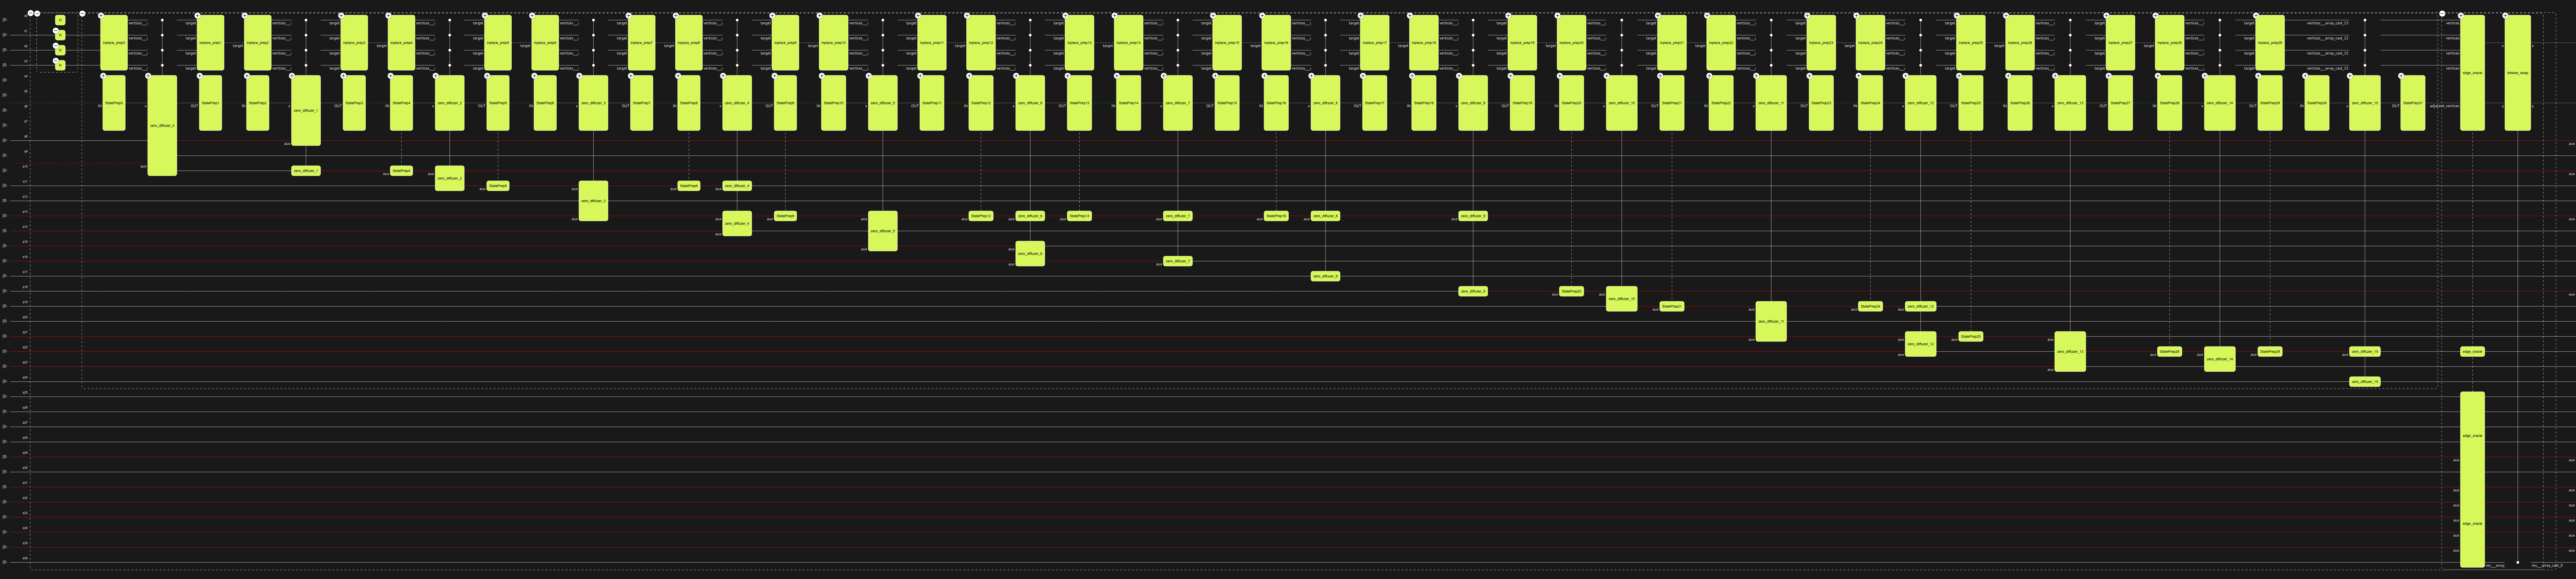

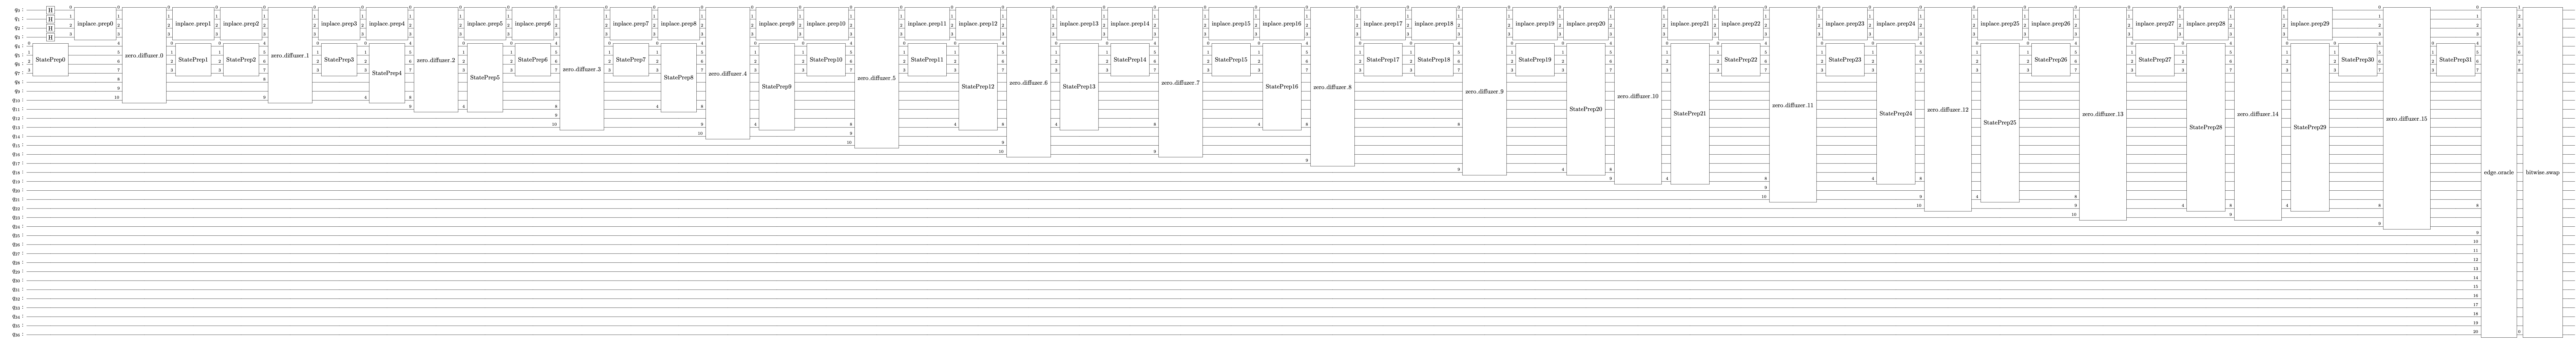

We tried to optimize the circuit to minimize its depth, but the resulting circuit is still too large. For analyze purpose, we tested with a smaller number of nodes, 4.

In [7]:
# We want a line with 16 nodes, 4 qubits needed
size = 2
nodes_count = 2**size

qmod = create_model(main)
qprog = synthesize(qmod)
show(qprog)
write_qmod(qmod, "quantum_walk")

Nodes and their probabilities initialization:

Node 0, prob vec is 	[0, 1, 0, 0]
Node 1, prob vec is 	[0.5, 0, 0.5, 0]
Node 2, prob vec is 	[0, 0.5, 0, 0.5]
Node 3, prob vec is 	[0, 0, 1, 0]


/var/folders/bh/ksldcyqj5_n29m6d776ng6f00000gn/T/ipykernel_13627/1393860104.py:18: DeprecationWarning: Parameter 'operand' of function 'control' has been renamed to 'stmt_block'. Parameter 'operand' will be deprecated in a future release.
Hint: Change `control(ctrl=..., operand=...)` to `control(ctrl=..., stmt_block=...)` or `control(..., ...)`.
  control(ctrl=vertices == i,
/var/folders/bh/ksldcyqj5_n29m6d776ng6f00000gn/T/ipykernel_13627/1393860104.py:19: DeprecationWarning: Parameters 'compute' and 'action' of function 'within_apply' have been renamed to 'within' and 'apply' respectively. Parameters 'compute' and 'action' will be deprecated in a future release.
Hint: Change `within_apply(compute=..., action=...)` to `within_apply(within=..., apply=...)` or `within_apply(..., ...)`.
  operand=lambda: within_apply(
/var/folders/bh/ksldcyqj5_n29m6d776ng6f00000gn/T/ipykernel_13627/1320354943.py:6: DeprecationWarning: Parameters 'compute' and 'action' of function 'within_apply' have been 

Opening: https://platform.classiq.io/circuit/51509e5d-bbe7-4e6f-8b2b-02f48d8c01c4?version=0.44.0


The resulting circuit:

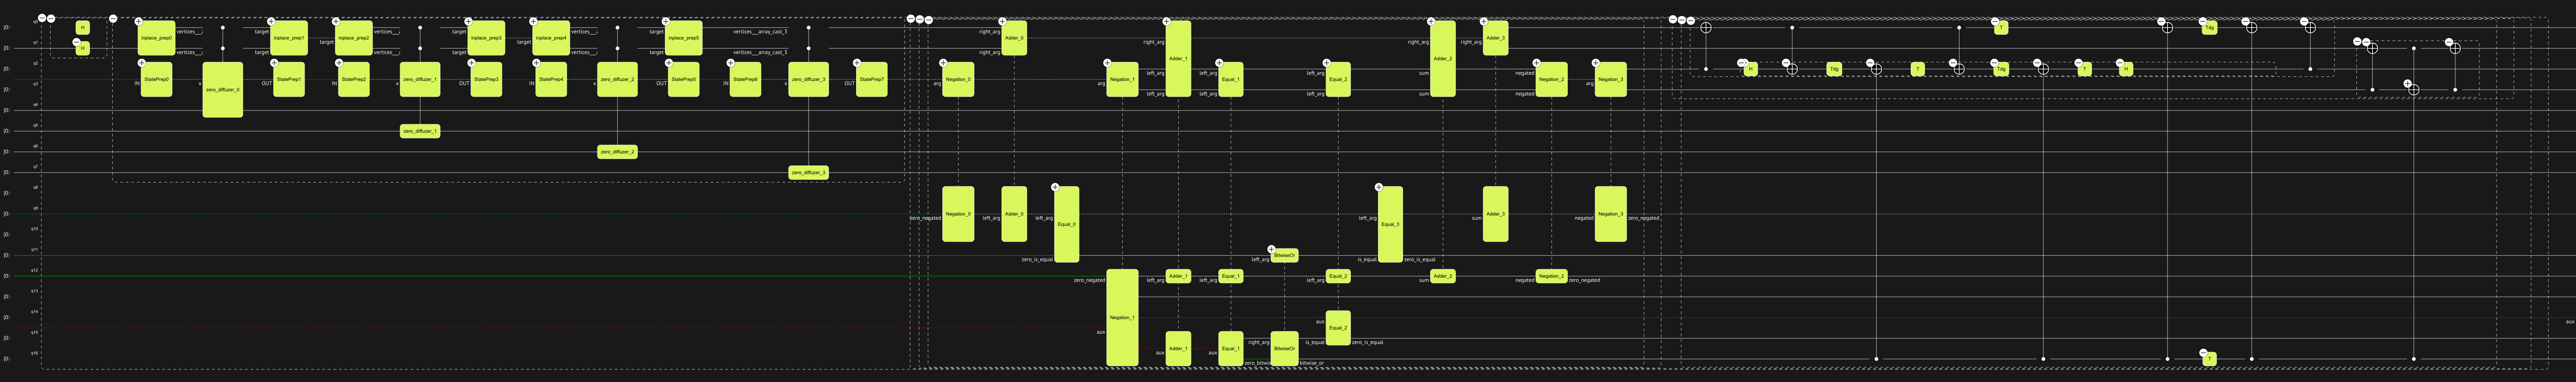

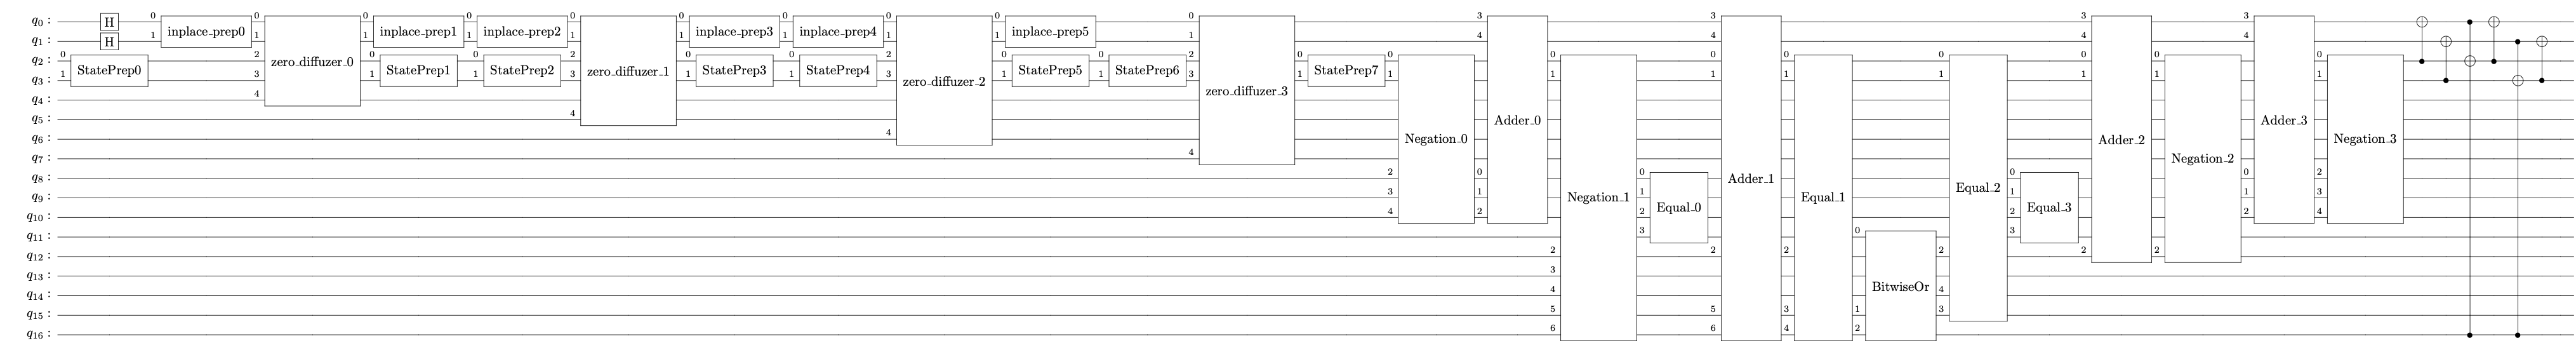